In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
from tensorflow import keras

import matplotlib.pyplot as plt

from scipy.stats import pearsonr, ttest_ind, ttest_1samp
import seaborn
from sklearn.decomposition import PCA
import random
from sklearn.model_selection import train_test_split


In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"], dataset = 'L1000')
# data_dict["complete"] = data_dict["complete"][data_dict["complete"].cell_id == "A549"].reset_index(drop = True)
meta_features = infer_L1000_features(data_dict["complete"], metadata=True)
L1000_features = infer_L1000_features(data_dict["complete"])
# second_df, data_dict["train"] = train_test_split(
#     data_dict["train"],
#     test_size=0.1,
#     random_state=99,
#     stratify=data_dict["train"].pert_id,
# )
data_dict["complete"] = data_dict["complete"].reset_index(drop = True)
complete_features_df = data_dict["complete"].reindex(L1000_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")
# complete_features_df = data_dict["complete"]
# input_dir = '../0.download-data/data/'
# complete_meta_df = pd.read_csv(input_dir + "col_meta_level_3_REP.A_A549_only_n27837.txt", sep = "\t")[['pert_id']]

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
latent_dim = 65
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [(latent_space_column) for latent_space_column in latent_space_columns]

In [5]:
encoder = keras.models.load_model("../2.train/L1000twolayerEncoder_mmd_leaveOut")
latent_df = pd.DataFrame(encoder.predict(complete_features_df)[2])

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: vae_utils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [6]:
# latent_df = pd.read_csv("latentOneLayer.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [7]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=complete_meta_df['pert_id']).reset_index().drop('pert_id',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['pert_id'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['pert_id'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['pert_id'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)


In [8]:
# meta_moa_latent_df = meta_moa_latent_df[meta_moa_latent_df.cell_id == "A549"].reset_index(drop = True)
# meta_moa_complete_df = meta_moa_complete_df[meta_moa_complete_df.cell_id == "A549"].reset_index(drop = True)
# meta_moa_pca_latent_df = meta_moa_pca_latent_df[meta_moa_pca_latent_df.cell_id == "A549"].reset_index(drop = True)

In [9]:
# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = pd.DataFrame([meta_moa_latent_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})

    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)
    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_latent_df

,random_moa_labels9,random_moa_labels8,random_moa_labels7,random_moa_labels6,random_moa_labels5,random_moa_labels4,random_moa_labels3,random_moa_labels2,random_moa_labels1,random_moa_labels0,...,55,56,57,58,59,60,61,62,63,64
0,p38 MAPK inhibitor,benzodiazepine receptor agonist,nucleoside reverse transcriptase inhibitor,proteasome inhibitor,maternal embryonic leucine zipper kinase inhib...,histamine receptor antagonist,FLT3 inhibitor,xanthine oxidase inhibitor,CDK inhibitor,MEK inhibitor,...,0.491854,-0.475018,-0.984446,-0.245492,1.482085,0.652117,-0.437846,0.127036,-0.195316,-0.557048
1,phosphodiesterase inhibitor,EGFR inhibitor,cyclooxygenase inhibitor,DMSO,cyclooxygenase inhibitor|prostanoid receptor a...,protease inhibitor,DMSO,HDAC inhibitor,cyclooxygenase inhibitor,cyclooxygenase inhibitor,...,0.010608,1.337731,-1.377801,-1.094352,-0.794444,-0.033085,0.831046,-0.072000,1.065844,-0.360268
2,CDK inhibitor,DNA synthesis inhibitor,dopamine reuptake inhibitor,adrenergic receptor agonist,bacterial DNA gyrase inhibitor,ion channel antagonist,CHK inhibitor|cytochrome P450 activator|indole...,NFkB pathway inhibitor|proteasome inhibitor,adrenergic receptor antagonist,adrenergic receptor agonist,...,-1.281380,-0.903298,-0.500726,0.438945,-0.501718,0.390613,0.616364,0.256614,-0.464855,-0.417628
3,selective estrogen receptor modulator (SERM),lipoxygenase inhibitor,cholesterol inhibitor|lipase clearing factor i...,calcium channel blocker,BCL inhibitor,histamine receptor antagonist,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,HIV integrase inhibitor,immunosuppressant,thyrotropin releasing hormone receptor agonist,...,-0.774753,1.530088,-0.724993,-0.259103,-0.090561,-0.141837,-0.199621,0.481446,-1.091197,-0.509413
4,ACAT inhibitor|sterol regulatory element bindi...,phosphodiesterase inhibitor,EGFR inhibitor,NFkB pathway inhibitor|proteasome inhibitor,DMSO,angiogenesis inhibitor|tumor necrosis factor p...,thrombin inhibitor,bacterial cell wall synthesis inhibitor,MEK inhibitor,DeltaF508-CFTR Correctors,...,0.838927,0.727625,0.292863,-1.098176,1.493311,1.585970,0.282334,0.334958,0.919857,0.112744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87489,histamine receptor antagonist,DMSO,AXL kinase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,proteasome inhibitor,adenylyl cyclase activator,estrogen receptor agonist,EGFR inhibitor,HDAC inhibitor,PPAR receptor agonist,...,-0.004361,1.199481,-1.605458,0.966721,1.381577,0.888050,0.843745,-0.445321,-0.412443,0.143413
87490,cyclooxygenase inhibitor,adrenergic receptor antagonist|calcium channel...,integrin antagonist,HMGCR inhibitor,endothelin receptor antagonist,RNA polymerase inhibitor,topoisomerase inhibitor,norepinephrine reputake inhibitor,ornithine decarboxylase inhibitor,gonadotropin releasing factor hormone receptor...,...,0.682432,-1.056453,-0.334581,0.527992,-0.697777,-1.243480,1.624857,0.759559,0.722502,-0.638662
87491,angiogenesis inhibitor|S100A9 inhibitor,bacterial DNA gyrase inhibitor,serotonin receptor agonist,cytidine deaminase inhibitor,proteasome inhibitor,PARP inhibitor,SRC inhibitor|VEGFR inhibitor,sodium/potassium/chloride transporter inhibitor,phosphodiesterase inhibitor,HDAC inhibitor,...,0.752568,-0.585888,-0.088464,-0.779527,-2.713717,0.969173,2.803679,0.351481,0.381277,-0.528385
87492,HDAC inhibitor,non-nucleoside reverse transcriptase inhibitor,PKC inhibitor,topoisomerase inhibitor,mTOR inhibitor|PI3K inhibitor,EGFR inhibitor,acetylcholine receptor agonist,antitumor agent|ribonucleotide reductase inhib...,EGFR inhibitor,glucose dependent insulinotropic receptor agonist,...,-1.666368,0.914074,-0.082771,-1.479653,-0.817053,-0.440106,2.159845,0.281428,0.151459,-0.287461


In [10]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
# valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 5) & (moas_occurrence['moa1 occurrence'] > 5)& (moas_occurrence['moa2 occurrence'] > 5)].index
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] >= 1) & (moas_occurrence['moa1 occurrence'] >= 1)& (moas_occurrence['moa2 occurrence'] >= 1)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [11]:
print(meta_moa_latent_df.shape)
print(meta_moa_complete_df.shape)
meta_moa_latent_df

(87494, 88)
(87494, 1001)


,random_moa_labels9,random_moa_labels8,random_moa_labels7,random_moa_labels6,random_moa_labels5,random_moa_labels4,random_moa_labels3,random_moa_labels2,random_moa_labels1,random_moa_labels0,...,55,56,57,58,59,60,61,62,63,64
0,p38 MAPK inhibitor,benzodiazepine receptor agonist,nucleoside reverse transcriptase inhibitor,proteasome inhibitor,maternal embryonic leucine zipper kinase inhib...,histamine receptor antagonist,FLT3 inhibitor,xanthine oxidase inhibitor,CDK inhibitor,MEK inhibitor,...,0.491854,-0.475018,-0.984446,-0.245492,1.482085,0.652117,-0.437846,0.127036,-0.195316,-0.557048
1,phosphodiesterase inhibitor,EGFR inhibitor,cyclooxygenase inhibitor,DMSO,cyclooxygenase inhibitor|prostanoid receptor a...,protease inhibitor,DMSO,HDAC inhibitor,cyclooxygenase inhibitor,cyclooxygenase inhibitor,...,0.010608,1.337731,-1.377801,-1.094352,-0.794444,-0.033085,0.831046,-0.072000,1.065844,-0.360268
2,CDK inhibitor,DNA synthesis inhibitor,dopamine reuptake inhibitor,adrenergic receptor agonist,bacterial DNA gyrase inhibitor,ion channel antagonist,CHK inhibitor|cytochrome P450 activator|indole...,NFkB pathway inhibitor|proteasome inhibitor,adrenergic receptor antagonist,adrenergic receptor agonist,...,-1.281380,-0.903298,-0.500726,0.438945,-0.501718,0.390613,0.616364,0.256614,-0.464855,-0.417628
3,selective estrogen receptor modulator (SERM),lipoxygenase inhibitor,cholesterol inhibitor|lipase clearing factor i...,calcium channel blocker,BCL inhibitor,histamine receptor antagonist,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,HIV integrase inhibitor,immunosuppressant,thyrotropin releasing hormone receptor agonist,...,-0.774753,1.530088,-0.724993,-0.259103,-0.090561,-0.141837,-0.199621,0.481446,-1.091197,-0.509413
4,ACAT inhibitor|sterol regulatory element bindi...,phosphodiesterase inhibitor,EGFR inhibitor,NFkB pathway inhibitor|proteasome inhibitor,DMSO,angiogenesis inhibitor|tumor necrosis factor p...,thrombin inhibitor,bacterial cell wall synthesis inhibitor,MEK inhibitor,DeltaF508-CFTR Correctors,...,0.838927,0.727625,0.292863,-1.098176,1.493311,1.585970,0.282334,0.334958,0.919857,0.112744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87489,histamine receptor antagonist,DMSO,AXL kinase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,proteasome inhibitor,adenylyl cyclase activator,estrogen receptor agonist,EGFR inhibitor,HDAC inhibitor,PPAR receptor agonist,...,-0.004361,1.199481,-1.605458,0.966721,1.381577,0.888050,0.843745,-0.445321,-0.412443,0.143413
87490,cyclooxygenase inhibitor,adrenergic receptor antagonist|calcium channel...,integrin antagonist,HMGCR inhibitor,endothelin receptor antagonist,RNA polymerase inhibitor,topoisomerase inhibitor,norepinephrine reputake inhibitor,ornithine decarboxylase inhibitor,gonadotropin releasing factor hormone receptor...,...,0.682432,-1.056453,-0.334581,0.527992,-0.697777,-1.243480,1.624857,0.759559,0.722502,-0.638662
87491,angiogenesis inhibitor|S100A9 inhibitor,bacterial DNA gyrase inhibitor,serotonin receptor agonist,cytidine deaminase inhibitor,proteasome inhibitor,PARP inhibitor,SRC inhibitor|VEGFR inhibitor,sodium/potassium/chloride transporter inhibitor,phosphodiesterase inhibitor,HDAC inhibitor,...,0.752568,-0.585888,-0.088464,-0.779527,-2.713717,0.969173,2.803679,0.351481,0.381277,-0.528385
87492,HDAC inhibitor,non-nucleoside reverse transcriptase inhibitor,PKC inhibitor,topoisomerase inhibitor,mTOR inhibitor|PI3K inhibitor,EGFR inhibitor,acetylcholine receptor agonist,antitumor agent|ribonucleotide reductase inhib...,EGFR inhibitor,glucose dependent insulinotropic receptor agonist,...,-1.666368,0.914074,-0.082771,-1.479653,-0.817053,-0.440106,2.159845,0.281428,0.151459,-0.287461


In [12]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [13]:
# subset = subset_by_moa("dopamine receptor antagonist|serotonin receptor antagonist", meta_moa_latent_df, 'moa')
# subset_mean = subset.groupby(['moa'])[latent_space_columns].mean()
# # subset_mean
# # meta_moa_latent_df[meta_moa_latent_df.moa == "NFkB pathway inhibitor|proteasome inhibitor"]np
# # subset
# subset.columns.to_list()

In [14]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []
subset_complete_means = []
subset_complete_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa'])[latent_space_columns].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa'])[latent_space_columns].mean()
    subset_complete = subset_by_moa(pipe, meta_moa_complete_df, 'moa')
    subset_complete_mean = subset_complete.groupby(['moa'])[complete_features_df.columns].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    subsets_complete_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, label)
        subset_random_mean = subset_random.groupby([label])[latent_space_columns].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, label)
        subset_pca_random_mean = subset_pca_random.groupby([label])[latent_space_columns].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
        
        subset_complete_random = subset_by_moa(pipe, meta_moa_complete_df, label)
        subset_complete_random_mean = subset_complete_random.groupby([label])[complete_features_df.columns].mean()
        subsets_complete_random_mean.append(subset_complete_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_complete_means.append(subset_complete_mean)
    
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    subset_complete_random_means.append(subsets_complete_random_mean)


In [15]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_complete = meta_moa_complete_df[meta_moa_complete_df.moa == 'DMSO']

DMSO_means = np.mean(DMSO[latent_space_columns])
DMSO_means_pca = np.mean(DMSO_pca[latent_space_columns])
DMSO_means_complete = np.mean(DMSO_complete[complete_features_df.columns])


DMSO_means_random = []
DMSO_means_pca_random = []
DMSO_means_complete_random = []

for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[latent_space_columns]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[latent_space_columns]))
    
    DMSO_complete_random = meta_moa_complete_df[meta_moa_complete_df[label] == 'DMSO']
    DMSO_means_complete_random.append(np.mean(DMSO_complete_random[complete_features_df.columns]))




In [16]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []
representations_after_LSA_complete = []
representations_after_LSA_complete_random = []


for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    
    representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca)
    representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
    representations_after_LSA_pca.append(representation_after_LSA_pca)
    
    representation_after_LSA_complete = LSA(subset_complete_means[i].loc[valid_pipes[i].split("|")[0]],subset_complete_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete)
    representation_after_LSA_complete = pd.DataFrame(representation_after_LSA_complete).transpose()
    representations_after_LSA_complete.append(representation_after_LSA_complete)
    
    
    LSA_random_1pipe = []
    PCA_random_1pipe = []
    complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
        representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
        LSA_random_1pipe.append(representation_after_LSA_random)    

        representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca_random[j])
        representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
        PCA_random_1pipe.append(representation_after_LSA_pca_random)
        
        representation_after_LSA_complete_random = LSA(subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete_random[j])
        representation_after_LSA_complete_random = pd.DataFrame(representation_after_LSA_complete_random).transpose()
        complete_random_1pipe.append(representation_after_LSA_complete_random)
        
    representations_after_LSA_random.append(LSA_random_1pipe)
    representations_after_LSA_pca_random.append(PCA_random_1pipe)
    representations_after_LSA_complete_random.append(complete_random_1pipe)

In [17]:
decoder = keras.models.load_model("../2.train/L1000twolayerDecoder_mmd_leaveOut")


In [18]:
#decode each latent space representation

predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []
predictions_complete = []
predictions_complete_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_pca.append(pca.inverse_transform(representations_after_LSA_pca[i]))
    predictions_complete.append(representations_after_LSA_complete[i].values.tolist())
    
    predictions_random_1pipe = []
    predictions_pca_random_1pipe = []
    predictions_complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][j]))
        predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][j]))
        predictions_complete_random_1pipe.append(representations_after_LSA_complete_random[i][j].values.tolist())

    predictions_random.append(predictions_random_1pipe)
    predictions_pca_random.append(predictions_pca_random_1pipe)
    predictions_complete_random.append(predictions_complete_random_1pipe)
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)
predictions_complete = np.array(predictions_complete)
predictions_complete_random = np.array(predictions_complete_random)

In [19]:
# mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'5720':]
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'780':]

# mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'200814_at':]
mean_of_moas = mean_of_moas[mean_of_moas.index.str.contains('\|')]

In [20]:
# #analyze results to see how good each prediction is to the actual value ranked against its distance to the values for other MOAs
# mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'5720':]
# performance_all_combo = []
# performance_all_combo_random = []

# for i in range(len(predictions)):
#     L2_distances = []
#     L2_distances_random = []
#     moas = []
#     for j in range(len(mean_of_moas)):
#         L2_distances.append(np.linalg.norm(mean_of_moas.iloc[j] - predictions[i][0]))
#         L2_distances_random.append(np.linalg.norm(mean_of_moas.iloc[j] - predictions_random[i][0]))
#         moas.append(mean_of_moas.index[j])
#     L2_distances = pd.DataFrame(L2_distances, columns = ["distance"])
#     L2_distances['moa'] = moas
#     L2_distances_random = pd.DataFrame(L2_distances_random, columns = ["distance"])
#     L2_distances_random['moa'] = moas
#     sorted_L2_distances = L2_distances.sort_values('distance').reset_index(drop = True)
#     sorted_L2_distances_random = L2_distances_random.sort_values('distance').reset_index(drop = True)
#     performance_all_combo.append(sorted_L2_distances[sorted_L2_distances.moa == valid_pipes_no_error[i]])
#     performance_all_combo_random.append(sorted_L2_distances_random[sorted_L2_distances_random.moa == valid_pipes_no_error[i]])

In [21]:
# rankings = []
# rankings_random = []
# for i in range(len(performance_all_combo)):
#     rankings.append(performance_all_combo[i].index[0])
#     rankings_random.append(performance_all_combo_random[i].index[0])

In [22]:
# fig, ax = plt.subplots(figsize=(13, 5))
# plt.hist(rankings_random, alpha = 0.5, label = "Shuffled")
# plt.hist(rankings, alpha = 0.5, label = "Unshuffled")
# plt.legend()
# plt.xlabel('Ranking')
# plt.show()

In [23]:
# #to see which MOA combo performed the best
# ranking_moa = pd.DataFrame()
# for i in range(len(performance_all_combo)):
#     ranking_moa = ranking_moa.append(performance_all_combo[i])
# ranking_moa.sort_index()

In [24]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
L2_complete = []
L2_complete_random = []

per_moa_pvalues_vae = []
per_moa_tstat_vae = []
per_moa_pvalues_pca = []
per_moa_tstat_pca = []
per_moa_pvalues_complete = []
per_moa_tstat_complete = []

for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    
    L2.append(np.linalg.norm(predictions[i][0]-desired_moa[0]))
    L2_pca.append(np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    L2_complete.append(np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))

    
    L2_random_per_moa = []
    L2_pca_random_per_moa = []
    L2_complete_random_per_moa = []
    for j in range(NUM_RANDOM_SAMPLES):
        L2_random_per_moa.append(np.linalg.norm(predictions_random[i][j][0]-desired_moa[0]))
        L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][j][0]-desired_moa[0]))
        L2_complete_random_per_moa.append(np.linalg.norm(predictions_complete_random[i][j][0]-desired_moa[0]))
    
    L2_random += L2_random_per_moa
    L2_pca_random += L2_pca_random_per_moa
    L2_complete_random += L2_complete_random_per_moa
    
    tstat_vae, pval_vae = ttest_1samp(L2_random_per_moa, np.linalg.norm(predictions[i][0]-desired_moa[0]))
    tstat_pca, pval_pca = ttest_1samp(L2_pca_random_per_moa, np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    tstat_complete, pval_complete = ttest_1samp(L2_complete_random_per_moa, np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))
        
    per_moa_pvalues_vae.append(pval_vae)
    per_moa_tstat_vae.append(tstat_vae)
    per_moa_pvalues_pca.append(pval_pca)
    per_moa_tstat_pca.append(tstat_pca)
    per_moa_pvalues_complete.append(pval_complete)
    per_moa_tstat_complete.append(tstat_complete)

In [25]:
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')

In [26]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae tstat')
well_predicted = per_moa_performance_df[per_moa_performance_df['vae tstat'] < 0]
well_predicted.to_csv('well_predicted.csv')
well_predicted

,MOA,vae pvalue,vae tstat,pca pvalue,pca tstat
34,AKT inhibitor|mTOR inhibitor,7.492016e-17,-159.777717,1.915215e-12,-51.663739
82,CDK inhibitor|glycogen synthase kinase inhibitor,4.900142e-16,-129.675173,3.467183e-12,-48.356191
20,benzodiazepine receptor agonist|HDAC inhibitor,1.465376e-15,-114.806816,1.037810e-12,-55.314270
51,cytochrome P450 inhibitor|protein synthesis in...,1.097548e-11,-42.523118,3.263063e-14,-81.300268
78,thromboxane receptor antagonist|thromboxane sy...,7.737129e-11,-34.186230,3.951340e-01,0.892948
63,interferon inducer|toll-like receptor agonist,1.700541e-08,-18.624521,2.398664e-01,1.258529
39,DNA synthesis inhibitor|microtubule inhibitor,2.553792e-08,-17.781940,1.424271e-11,-41.304008
55,cyclooxygenase inhibitor|lipoxygenase inhibitor,5.902741e-08,-16.158432,9.930350e-04,4.785918
54,acetylcholinesterase inhibitor|microtubule inh...,1.861743e-07,-14.157540,3.545403e-08,-17.128670
11,cyclooxygenase inhibitor|opioid receptor agonist,6.120190e-07,-12.327393,4.317602e-03,3.784714


In [27]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')

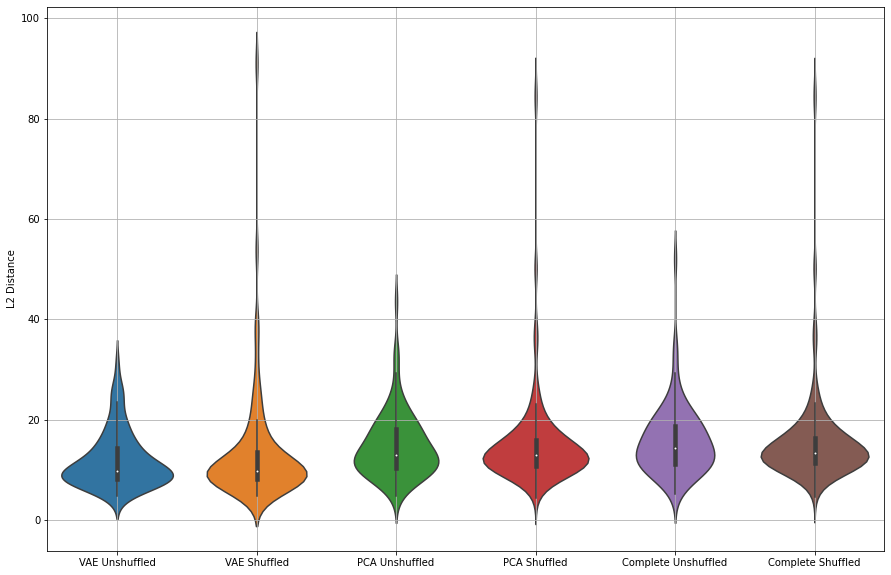

In [28]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [29]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,85.000000,850.000000,85.000000,850.000000,85.000000,850.000000
mean,11.977631,13.465259,14.851759,15.282062,15.807188,15.815503
std,5.552033,11.634652,6.506581,9.964091,6.939750,9.842096
min,4.799361,4.819260,4.775624,4.352638,5.145844,4.640652
25%,8.199465,8.095870,10.407399,10.805273,11.209651,11.453305
50%,9.800642,9.795761,12.915925,12.897591,14.334111,13.440395
75%,14.415607,13.514964,18.044752,15.902324,18.749869,16.383974
max,31.266419,91.259927,43.598838,87.000367,52.022107,87.029381


In [30]:
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled'].dropna()))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))


# 11.97, 12.7, 0.56
#11.151807	12.170750 0.48
#12.138769	12.577573
#12.723207	13.823311	0.4
# 1 layer beta 10 = 13.514142	15.608738 p=0.073
# 1 layer beta 30 = 13.245158	15.531089
# 1 layer beta 50 = 13.232101	15.450388 p = 0.060
# 1 layer beta 60 = 13.231065	15.393886 p = 0.068
# 1 layer beta 70 = 13.242314	15.329598 p = 0.077
# 1 layer beta 110 = 13.249500	15.330011 p = 0.0788
# 2 layer beta 10 = 13.247328	13.901505 p = 0.63
# 2 layer beta 40 = 12.562742	13.861876 p = 0.33
# 2 layer beta 60 = 12.376956	13.821200 p = 0.28
# 2 layer beta 80 = 12.730887	13.775652 p = 0.435
# 2 layer beta 110 = 13.028115	13.797308 p = 0.57
# 4 layer beta 10 = 14.356435	14.063442 p = --
# 4 layer beta 60 = 13.192651	14.004423 p= 0.54
# 4 layer beta 110 = 12.791794	13.927948 p = 0.38
# 4 layer beta 160 = 13.145475	13.894073 p = 0.57
#22

Ttest_indResult(statistic=-1.1652062480066625, pvalue=0.24423333028795616)
Ttest_indResult(statistic=-0.38981904268728806, pvalue=0.6967593297625898)
Ttest_indResult(statistic=-0.007600347980391355, pvalue=0.9939374828212117)
